Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import difflib
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics .pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib
import matplotlib.pyplot as plt

Data Collection and preproccesing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load dataset
music_data = pd.read_csv('/content/drive/MyDrive/Bangla_Music/song_data.csv')
#66mail##music_data = pd.read_csv('/content/drive/MyDrive/Bangla_music/song_data.csv')

#music_label = pd.read_csv('/content/drive/MyDrive/Bangla_Music/dataset.csv')
df = pd.DataFrame(music_data)
df= df.drop('index',axis = 'columns')
music_data = df.drop_duplicates(keep = 'first')
#music_data= np.loadtxt('song_data.csv', delimiter=',')
#music_data= np.unique(music_data,axis=0)
#print(music_data)
music_data.head()
#music_label.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,label
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474,Popular
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370,Popular
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324,Popular
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198,Popular
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574,Popular


In [ ]:
music_data.reset_index(inplace = True)
music_data['index'] = 0
for i, row in music_data.iterrows():
  music_data['index'][i] = i

print(music_data)

       index                   song_name  song_popularity  song_duration_ms  \
0          0  Boulevard of Broken Dreams               73            262333   
1          1                  In The End               66            216933   
2          2           Seven Nation Army               76            231733   
3          3                  By The Way               74            216933   
4          4           How You Remind Me               56            223826   
...      ...                         ...              ...               ...   
14921  14921              Let It Breathe               60            159645   
14922  14922                     Answers               60            205666   
14923  14923      Sudden Love (Acoustic)               23            182211   
14924  14924           Gentle on My Mind               55            352280   
14925  14925                    Up to Me               60            193533   

       acousticness  danceability  energy  instrume

In [ ]:
music_data.shape

(14926, 17)

In [ ]:
selected_features=['song_name','song_popularity','song_duration_ms','tempo','label']
print(selected_features)
music_data['song_popularity'] = music_data['song_popularity'].astype(float)
music_data['song_duration_ms'] = music_data['song_duration_ms'].astype(float)
music_data['tempo'] = music_data['tempo'].astype(float)


['song_name', 'song_popularity', 'song_duration_ms', 'tempo', 'label']


In [ ]:
# from sklearn.neighbors import NearestNeighbors
# from sklearn.preprocessing import MinMaxScaler


# # preprocess the tempo, duration, and popularity columns by converting to float and scaling
# scaler = MinMaxScaler()
# music_data[[ 'song_popularity','song_duration_ms','tempo']] = scaler.fit_transform(music_data[['song_popularity','song_duration_ms','tempo']])



# # define the feature matrix X (tempo, duration, and popularity columns)
# X = music_data[['song_popularity','song_duration_ms','tempo']]

# # instantiate a NearestNeighbors object
# knn = NearestNeighbors(n_neighbors=5)

# # fit the KNN model to the feature matrix
# knn.fit(X)

# def recommend_songs(song_title, n_neighbors=5):
#     # find the tempo, duration, and popularity of the input song
#     input_song = music_data[music_data['song_name'] == song_title]
#     if input_song.empty:
#         return "Song not found."
#     input_features = input_song[['tempo', 'song_duration_ms', 'song_popularity']].values

#     # scale the input features using the same scaler used on the training data
#     input_features = scaler.transform(input_features)

#     # find the nearest neighbors to the input song
#     distances, indices = knn.kneighbors(input_features, n_neighbors=n_neighbors+1)

#     # get the similarity scores for the nearest neighbors
#     similarity_scores = 1 / (1 + distances)

#     # exclude the input song itself from the recommendations
#     indices = indices[0][1:]
#     similarity_scores = similarity_scores[0][1:]

#     # create a list of tuples containing the song titles and similarity scores
#     recommended_songs = [(music_data.iloc[index]['song_name'], similarity_scores[i]) for i, index in enumerate(indices)]

#     # handle the case where recommended_songs contains only one tuple
#     if len(recommended_songs) == 1:
#         song, score = recommended_songs[0]
#         print(song, "(similarity score: " + str(score) + ")")
#     else:
#         for song, score in recommended_songs:
#             print(song, "(similarity score: " + str(score) + ")")
# # example usage:
# input_song = 'In The End'
# print(f"Recommendations {input_song}:")
# y=recommend_songs(input_song)

# if y is None:
#     y = ""
# print(y)  # recommend songs with similar features to Song A



In [ ]:
def recommend_songs(song_title, n_neighbors=5):
    # find the tempo, duration, and popularity of the input song
    input_song = music_data[music_data['song_name'] == song_title]
    if input_song.empty:
        return "Song not found."
    input_features = input_song[['tempo', 'song_duration_ms', 'song_popularity']].values

    # scale the input features using the same scaler used on the training data
    input_features = scaler.transform(input_features)

    # find the nearest neighbors to the input song
    distances, indices = knn.kneighbors(input_features, n_neighbors=n_neighbors+1)

    # get the similarity scores for the nearest neighbors
    similarity_scores = 1 / (1 + distances)

    # exclude the input song itself from the recommendations
    indices = indices[0][1:]
    similarity_scores = similarity_scores[0][1:]

    # create a list of tuples containing the song titles and similarity scores
    recommended_songs = [(music_data.iloc[index]['song_name'], similarity_scores[i]) for i, index in enumerate(indices)]

    # return the list of recommended songs and their similarity scores
    return recommended_songs

In [ ]:
input_song = 'In The End'
print(f"Recommendations {input_song}:")
recommended_songs = recommend_songs(input_song)
if recommended_songs == "Song not found.":
    print(recommended_songs)
else:
    for song, score in recommended_songs:
        print(song, "(similarity score: " + str(score) + ")")

Recommendations In The End:
Side To Side (similarity score: 0.9925557878452497)
Both of Us (similarity score: 0.988724117161025)
Desafío (similarity score: 0.9884605571668589)
Surf Wave (similarity score: 0.9858782219490302)
Old Town (similarity score: 0.9841360838264419)


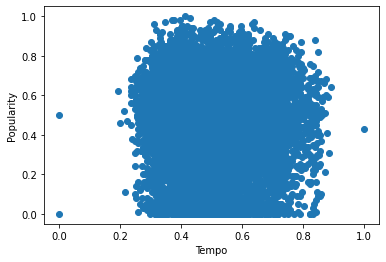

In [ ]:
import matplotlib.pyplot as plt

# plot tempo vs popularity
plt.scatter(music_data['tempo'], music_data['song_popularity'])
plt.xlabel('Tempo')
plt.ylabel('Popularity')
plt.show()

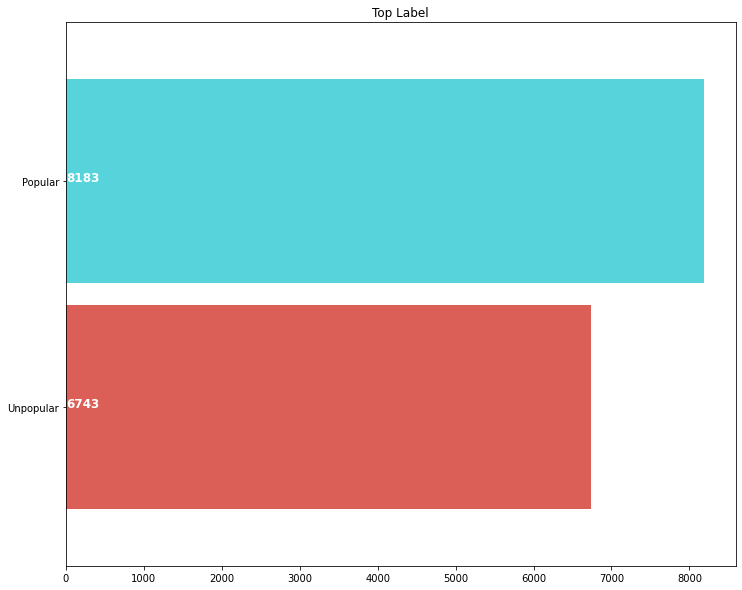

In [ ]:
music_data['label'] = music_data['label'].str.strip('[]').str.replace(' ','').str.replace("'",'')
music_data['label'] = music_data['label'].str.split(',')

plt.subplots(figsize=(12,10))
list1 = []
for i in music_data['label']:
    list1.extend(i)
ax = pd.Series(list1).value_counts()[:2].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('hls',2))
for i, v in enumerate(pd.Series(list1).value_counts()[:2].sort_values(ascending=True).values):
    ax.text(.8, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Label')
plt.show()

In [ ]:
# converting int and float value to string
int_cols = music_data.select_dtypes(include=['int64']).columns
music_data[int_cols] = music_data[int_cols].astype(str)


float_cols = music_data.select_dtypes(include=['float64']).columns
music_data[float_cols] = music_data[float_cols].astype(str)

music_data.head()
#setting all the null value to null string

for feature in selected_features:
  music_data[feature] = music_data[feature].fillna(0)


In [ ]:
music_data.head()

,index,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,label
0,0,Boulevard of Broken Dreams,0.73,0.1400585001449076,0.00552,0.496,0.682,2.94e-05,8,0.0589,-4.095,1,0.0294,0.6894246403486327,4,0.474,Popular
1,1,In The End,0.66,0.11465771037057179,0.0103,0.542,0.853,0.0,3,0.108,-6.407,0,0.0498,0.43437136324994424,4,0.37,Popular
2,2,Seven Nation Army,0.76,0.12293814404150064,0.00817,0.737,0.463,0.447,0,0.255,-7.828,1,0.0792,0.51123317293804,4,0.324,Popular
3,3,By The Way,0.74,0.11465771037057179,0.0264,0.451,0.97,0.00355,0,0.102,-4.938,1,0.107,0.5053029490174069,4,0.198,Popular
4,4,How You Remind Me,0.56,0.11851426640393076,0.000954,0.447,0.766,0.0,10,0.113,-5.065,1,0.0313,0.7098564695978011,4,0.574,Popular


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

combined_features = music_data[selected_features].apply(lambda x: ' '.join(selected_features), axis=1)
#combined_features = music_data['label']+' '+music_data['song_popularity']+' '+music_data['song_duration_ms']+' '+music_data['tempo']
#combined_features
#converting the text data to feature vector
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)
#print(feature_vectors)


#find similarity
similarity=cosine_similarity(feature_vectors)
print(similarity)



music_name = input("Enter a song name : ")

music_list = music_data['song_name'].tolist()
find_close_match = difflib.get_close_matches(music_name,music_list)
close_match = find_close_match[0]
#print(music_list)
#print(close_match)


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Enter a song name : IN the end


In [ ]:
index_of_music_str = music_data[music_data.song_name == close_match]['index'].values[0]
index_of_music=int(index_of_music_str)
print(index_of_music)


similarity_score = list(enumerate(similarity[index_of_music]))
print(similarity_score)
len(similarity_score)

1
[(0, 1.0000000000000002), (1, 1.0000000000000002), (2, 1.0000000000000002), (3, 1.0000000000000002), (4, 1.0000000000000002), (5, 1.0000000000000002), (6, 1.0000000000000002), (7, 1.0000000000000002), (8, 1.0000000000000002), (9, 1.0000000000000002), (10, 1.0000000000000002), (11, 1.0000000000000002), (12, 1.0000000000000002), (13, 1.0000000000000002), (14, 1.0000000000000002), (15, 1.0000000000000002), (16, 1.0000000000000002), (17, 1.0000000000000002), (18, 1.0000000000000002), (19, 1.0000000000000002), (20, 1.0000000000000002), (21, 1.0000000000000002), (22, 1.0000000000000002), (23, 1.0000000000000002), (24, 1.0000000000000002), (25, 1.0000000000000002), (26, 1.0000000000000002), (27, 1.0000000000000002), (28, 1.0000000000000002), (29, 1.0000000000000002), (30, 1.0000000000000002), (31, 1.0000000000000002), (32, 1.0000000000000002), (33, 1.0000000000000002), (34, 1.0000000000000002), (35, 1.0000000000000002), (36, 1.0000000000000002), (37, 1.0000000000000002), (38, 1.000000000000

14926

In [ ]:
sorted_similar_musics = sorted(similarity_score,key = lambda x:x[1],reverse=True)

i = 1
print("Recommendant musics : ")
for music in sorted_similar_musics:
  index = music[0]
  title_from_index =  music_data[music_data.index==index]['song_name'].values[0]
  if(i<5 ):

    print(i,'.',title_from_index)
    i+=1

Recommendant musics : 
1 . Boulevard of Broken Dreams
2 . In The End
3 . Seven Nation Army
4 . By The Way
